# Isolated substorm detection using autoencoders : normalized data

Substorms are of particular interest to researchers. They are a common phenomenon and it is difficult to detect isolated events for study. Finding such events must be done by hand which is a tedious task.

In the following we study the application of autoencoders to the problem of detecting substorm events. 

## Common imports


In [1]:
import sys
sys.path.insert(0,"..")

import datetime
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn.functional as F
import torch.optim as optim

# kNN
import sklearn
from sklearn import neighbors

# Data loader class
from isolated_substorms.dataset import Dataset
# Label loader class
from isolated_substorms.labels import EventLabels
# Autoencoder classes
from isolated_substorms.train_history import TrainHistory
from isolated_substorms.autoencoder import Encoder, Decoder, TrainableAutoencoder, TestAutoencoder
# f1 score
from isolated_substorms.metrics import f1_score

In [2]:
# some configuration
pickle_filename="autoencoder_feature_data_normalized.pkl"


## Load data

First load the full historical AL data and the labels. We then extract data for training and validation. Test data is all data that hasn't been labeled.

In [3]:
# get the labels
labels=EventLabels()
print("Number of events         : {}".format(labels.size()))
print("Label timespan           : {}".format(labels.timespan()))

# get AL data
historical_data=Dataset()
# keep only data for which we have labels
labeled_data=historical_data.get_timespan(labels.timespan())
print("Labeled data shape       : {}".format(labeled_data.shape))
p=100.*float(labeled_data.shape[0])/historical_data.data.shape[0]
print("Proportion of total data : {} %".format(p))

# labeled data description
labeled_data_mean=np.mean(labeled_data)
labeled_data_std=np.std(labeled_data)
print("Labeled data mean        : {}".format(labeled_data_mean))
print("Labeled data standard dev: {}".format(labeled_data_std))

Number of events         : 76
Label timespan           : 1992-10-13 06:27:26 -> 1993-02-15 01:33:40
Labeled data shape       : (179946,)
Proportion of total data : 3.416106383657303 %
Labeled data mean        : -141.652167872584
Labeled data standard dev: 167.2879219136791


### Data description

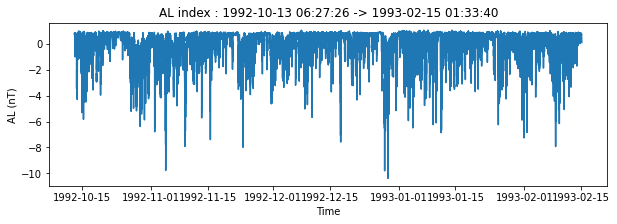

In [4]:
# plot the AL index 
labeled_data=(labeled_data-labeled_data_mean)/labeled_data_std
plt.figure(figsize=(10,3))
plt.plot(labeled_data)
plt.title("AL index : {}".format(labels.timespan()))
plt.xlabel("Time")
plt.ylabel("AL (nT)")
plt.show()

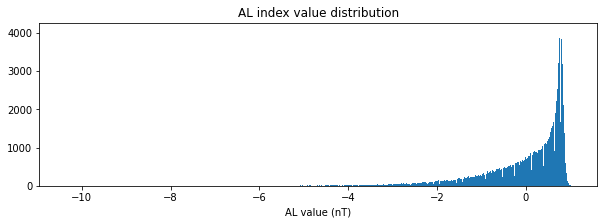

In [5]:
# AL index value distribution
plt.figure(figsize=(10,3))
plt.title("AL index value distribution")
plt.hist(labeled_data, bins=1000)
plt.xlabel("AL value (nT)")
plt.show()

## Training data

The presence of a substorm event at time `t` is dictated by the behaviour of the index `before` and `after` time `t`. Each sample given to our detection model will be a window of size `window_size` centered on the event onset.

We chose a `window_size` of 180 points, representing 3 hours of data.

To avoid generating the features everytime we restart the kernel we will save the data with pickle in the `autoencoder_feature_data_normalized.pkl`.

In [6]:
# equalize classes

def equalize_classes(x,y,weights):
    # positive labels
    x_positive=x[y==1]
    n_positive=x_positive.shape[0]
    # negative labels
    x_negative=x[y==0]
    # shuffle the negative labels
    x_negative=sklearn.utils.shuffle(x_negative)
    # concatenate positive and negative samples
    x_temp=np.concatenate((x_positive,x_negative[:n_positive]),axis=0)
    y_temp=np.concatenate((np.ones(n_positive),np.zeros(n_positive)),axis=0)
    return sklearn.utils.shuffle(x_temp,y_temp)
    
# convert dataset and labels to features that we can use to train the model
def dataset_to_features(data, labels, window_size=180):
    n=data.shape[0]
    w_delta=int(window_size/2)
    # feature and label containers
    x,y=np.empty((n-window_size,window_size)),np.empty(n-window_size)
    for i in range(w_delta,n-w_delta):
        x[i-w_delta]=data[i-w_delta:i+w_delta].to_numpy()
        y[i-w_delta]=labels.check_date(data.index[i])
    # equalize classes
    xh,yh=equalize_classes(x,y,weights=[.5,.5])
    return x,y,xh,yh


if not os.path.exists(pickle_filename):
    print("Saving features to {}".format(pickle_filename))
    x_full,y_full,x,y=dataset_to_features(labeled_data, labels)
    pkl.dump((x_full,y_full,x,y),open(pickle_filename,"wb"))
else:
    print("Loading features from {}".format(pickle_filename))
    x_full,y_full,x,y=pkl.load(open(pickle_filename,"rb"))

X=x
Y=y
for i in range(10):
    X=np.concatenate((X,x),axis=0)
    Y=np.concatenate((Y,y),axis=0)
x=X+.1*np.random.normal(size=X.shape)
y=Y

Loading features from autoencoder_feature_data_normalized.pkl


Split the data into training and validation sets.

In [7]:
# split into training and validation sets
def split_data(x,y,p=.5):
    n=x.shape[0]
    np=int(p*n)
    return torch.from_numpy(x[:np]).float(),\
           torch.from_numpy(y[:np]).float(),\
           torch.from_numpy(x[np:]).float(),\
           torch.from_numpy(y[np:]).float()

x_train,y_train,x_validation,y_validation=split_data(x,y,.66)

## Autoencoder initialization

In [8]:
encoding_dim=2
class EncoderA(Encoder):
    def __init__(self,code_dim=2):
        super(EncoderA,self).__init__()
        self.l1=torch.nn.Linear(180,code_dim)
    def forward(self, x):
        x=self.l1(x)
        return x
class DecoderA(Decoder):
    def __init__(self,code_dim=2):
        super(DecoderA,self).__init__()
        self.l1=torch.nn.Linear(code_dim,180)
    def forward(self, x):
        x=self.l1(x)
        return x


### Training the model

Parameters used for training. Implemented early stopping with patience value of 10.

| Parameter            | Variable name | Value |
| -------------------- |:-------------:| -----:|
| learning rate        | lr            | 1.e-6 |
| validation tolerance | validation_tol| 1.e-10 |

---------

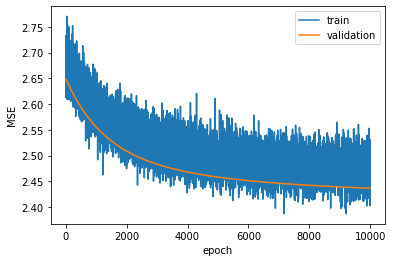

In [9]:
lr=0.000001
validation_tol=1.e-10
autoencoder=TrainableAutoencoder(encoder=EncoderA(),\
                                 decoder=DecoderA())
train_history = autoencoder.train(x_train, x_train,\
                                  x_validation, x_validation,\
                                  lr=lr,\
                                  val_tol=validation_tol)
train_loss_fig=train_history.plot()
plt.show()

### Prediction

Lets plot the encoded data in the first two dimensions of the encoding space. The `positive` labels are shown in red and the `negative` samples blue. The hope is that the encoded data will have evident clusters. Predicting is then done by using k-Nearest Neighbors algorithm.

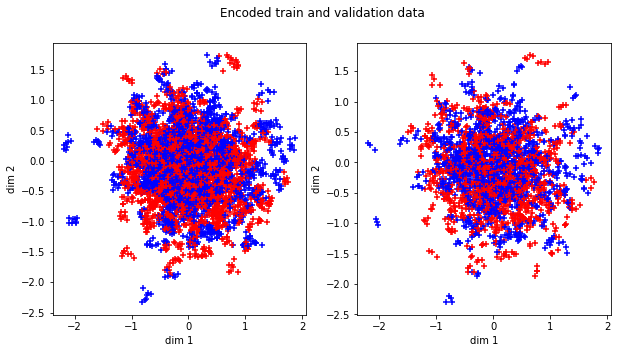

In [10]:
# plot train and validation encoded data
with torch.no_grad():
    encoded_train=autoencoder.encoder(x_train)
    encoded_validation=autoencoder.encoder(x_validation)
    encoded_full=autoencoder.encoder(torch.from_numpy(x_full).float())
# map labels to colors
cmap={0:"b",1:"r"}
colors_train=[cmap[int(k.item())] for k in y_train]
colors_validation=[cmap[int(k.item())] for k in y_validation]

plt.figure(figsize=(10,5))
plt.suptitle("Encoded train and validation data")
plt.subplot(1,2,1)
plt.scatter(encoded_train[:,0],encoded_train[:,1],\
            marker="+",c=colors_train)
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.subplot(1,2,2)
plt.scatter(encoded_validation[:,0],encoded_validation[:,1],\
           marker="+",c=colors_validation)
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.show()

It is difficult to distinguish any clusters due to the fact that the `negative` samples far outnumber the `positive` samples. 

For future reference we will evaluate the current models performance on the full labeled dataset.

## k-NN classifier
Train the classifier on the train data.

In [11]:
# classifier initializing and training
clf=neighbors.KNeighborsClassifier(n_neighbors=10, weights="uniform")
clf.fit(encoded_train, y_train)
prediction=clf.predict(encoded_full)
df=pd.DataFrame({"prediction":prediction,"actual":y_full},columns=["prediction","actual"])
confusion_matrix=pd.crosstab(df["prediction"],df["actual"])
print("Confusion matrix :\n{}".format(confusion_matrix))
print("F1 score         : {}".format(f1_score(prediction,y_full)))

Confusion matrix :
actual        0.0  1.0
prediction            
0.0         99102  215
1.0         80310  139
F1 score         : 0.003440466319319827


How does the `F1 score` evolve as a function of the number of neighbors ?

0.00 1.02 2.04 3.06 4.08 5.10 6.12 7.14 8.16 9.18 10.20 11.22 12.24 13.27 14.29 15.31 16.33 17.35 18.37 19.39 20.41 21.43 22.45 23.47 24.49 25.51 26.53 27.55 28.57 29.59 30.61 31.63 32.65 33.67 34.69 35.71 36.73 37.76 38.78 39.80 40.82 41.84 42.86 43.88 44.90 45.92 46.94 47.96 48.98 50.00 51.02 52.04 53.06 54.08 55.10 56.12 57.14 58.16 59.18 60.20 61.22 62.24 63.27 64.29 65.31 66.33 67.35 68.37 69.39 70.41 71.43 72.45 73.47 74.49 75.51 76.53 77.55 78.57 79.59 80.61 81.63 82.65 83.67 84.69 85.71 86.73 87.76 88.78 89.80 90.82 91.84 92.86 93.88 94.90 95.92 96.94 97.96 98.98 

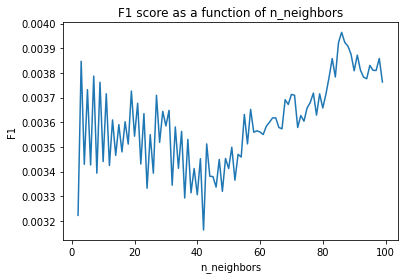

In [12]:
n_neighbors=[nei for nei in range(2,100,1)]
scores=np.empty(len(n_neighbors))
for i in range(len(n_neighbors)):
    progress=100.* float(i)/len(n_neighbors)
    sys.stdout.write("{:.2f} ".format(progress))
    sys.stdout.flush()
    clf=neighbors.KNeighborsClassifier(n_neighbors=n_neighbors[i], weights="uniform")
    clf.fit(encoded_train, y_train)
    prediction=clf.predict(encoded_full)
    scores[i]=f1_score(prediction,y_full)

plt.figure()
plt.title("F1 score as a function of n_neighbors")
plt.plot(n_neighbors, scores)
plt.xlabel("n_neighbors")
plt.ylabel("F1")
plt.show()

In [13]:
class EncoderB(Encoder):
    def __init__(self, code_dim):
        super(EncoderB,self).__init__()
        self.l1=torch.nn.Linear(180,64)
        self.l2=torch.nn.Linear(64,code_dim)
    def forward(self, x):
        x=F.relu(self.l1(x))
        x=F.relu(self.l2(x))
        return x
class DecoderB(Decoder):
    def __init__(self, code_dim):
        super(DecoderB,self).__init__()
        self.l1=torch.nn.Linear(code_dim,64)
        self.l2=torch.nn.Linear(64,180)
    def forward(self, x):
        x=F.relu(self.l1(x))
        x=F.relu(self.l2(x))
        return x
# pack it all in a container class
class SubstormDetectorA:
    def __init__(self, encoding_dim, n_neighbors):
        self.autoencoder=TrainableAutoencoder(encoder=EncoderB(encoding_dim),\
                                             decoder=DecoderB(encoding_dim))
        self.clf=neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, weights="uniform")
    def fit(self):
        self.autoencoder.train(x_train,x_train,\
                               x_validation, x_validation,\
                              lr=0.00000001, val_tol=1.e-15)
        # encode train data
        with torch.no_grad():
            encode_train=self.autoencoder.encoder(x_train)
        self.clf.fit(encode_train,y_train)
    def predict(self, x):
        pass
    def encode(self, x):
        with torch.no_grad():
            return self.autoencoder.encoder(torch.from_numpy(x).float())
    def evaluate(self, x, y):
        encoded=self.encode(x)
        return f1_score(self.clf.predict(encoded),y)

validation score not improving. ending training
validation score not improving. ending training
validation score not improving. ending training
validation score not improving. ending training
validation score not improving. ending training
validation score not improving. ending training
validation score not improving. ending training


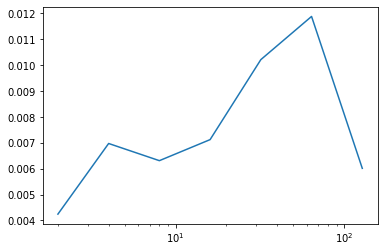

In [14]:
scores=[]
code_sizes=[2,4,8,16,32,64,128]
for i in range(len(code_sizes)):
    detector=SubstormDetectorA(code_sizes[i],10)
    detector.fit()
    scores.append(detector.evaluate(x_full,y_full))
plt.figure()
plt.plot(code_sizes, scores)
plt.xscale("log")
plt.show()